<a href="https://colab.research.google.com/github/fluxtransport/HelioLectures/blob/commit_from_colab/notebooks/sunspot_lecture_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sunspot models lecture part 2

### Jupyter notebook demonstrating how to inspect physical properties of a MURaM sunspot simulation. 

### notebook author: Mark Cheung, fluxtranport@github

### *** Acknowledgment ***

### Please cite "Rempel 2012, ApJ 750, 62" in manuscripts or presentations that result from the use of the data.  

### So that we may acknowledge any use of the data in our own reports and presentations, please send any electronic preprints (or web links) of manuscripts which use the data to rempel@ucar.edu. This may be done after a manuscript is submitted or accepted for publication.  For all publications and presentations of results using this data, please add the following acknowledgments:

### We use data provided by M. Rempel at the National Center for Atmospheric Research (NCAR). The National Center for Atmospheric Research is sponsored by the National Science Foundation. 
------------------------------------------------------------------------
Data format:
All data consists of single precision little endian binary files. Each
variable is stored in a separate file containing an array for the size
nx*ny*nz (see below). 

#### Here "y" refers to the vertical direction, similarly vely and magy are the vertical field components. All quantities are in cgs units. Positive values of vely indicate upflows.



### slab_12x8x12km_ng:
This data set is derived from a (grey) sunspot simulation at originally 
16x12x16 km resolution in a 49.152x6.144x49.152 Mm domain. The top
half of that domain was regridded to 12x8x12 km resolution and evolved for
another 15 minutes (10 min grey and the last 5 min non-grey). We make here
a cut through the center of the domain available, the data cube has a size
of 4096x256x512. 

In [ ]:
import numpy as np
import xarray as xp
import bokeh
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import RegularGridInterpolator, interp1d
import urllib
import sys


class ProgressBar: #from https://stackoverflow.com/questions/43370284/why-function-works-properly-without-specifying-parameters
    def __init__(self):
        self.old_percent = 0
        print('_' * 50)

    def download_progress_hook(self, count, blockSize, totalSize):
        percent = int(count * blockSize * 100 / totalSize)
        if percent >= 2 + self.old_percent:
            self.old_percent = percent
            # print(percent, '%')
            print('>', end='')
            sys.stdout.flush()
        if percent == 100:
            print('\ndone!')
            
def download_if_no_local_copy(file):
    progress = ProgressBar()
    base = 'https://download.hao.ucar.edu/pub/rempel/sunspot_models/Fine_Structure/slab_12x8x12km_ng/'
    # See https://download.hao.ucar.edu/pub/rempel/sunspot_models/Fine_Structure/ for other model snapshots
    try:
        if os.path.getsize(file) != 2147483648:
            print('Downloading', file.split('/')[-1])
            urllib.request.urlretrieve(base+file.split('/')[-1], file, reporthook=progress.download_progress_hook)            
        else:
            print(file, ' exists and has the correct size')
    except:
        print('Downloading', file.split('/')[-1])
        urllib.request.urlretrieve(base+file.split('/')[-1], file, reporthook=progress.download_progress_hook)

In [ ]:
# Download data if necessary
path = './'
for var in ['tauc', 'magx', 'magy', 'magz', 'velx', 'vely', 'velz', 'pres', 'temp']:
    download_if_no_local_copy(path+var+'.float')

__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!
__________________________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
done!


In [ ]:
# Let's load some MHD variables of a snapshot
shape = (4096,256,512) # x, y (vertical), z
dx = np.array((12,8,12))/1e3 #Grid spacing in Mm
x = (np.arange(shape[0])+0.5-shape[0]/2)*dx[0] # x coords in Mm
y = (np.arange(shape[1])+0.5)*dx[1] # y coords in Mm
z = (np.arange(shape[2])+0.5-shape[2]/2)*dx[2] # z coords in Mm
tau = np.memmap(path+"tauc.float", shape=shape, dtype=np.float32, order="F") # unitless optical depth at 500 nm continuum for vertical rays
bx = np.memmap(path+"magx.float", shape=shape, dtype=np.float32, order="F") #Gauss
bz = np.memmap(path+"magz.float", shape=shape, dtype=np.float32, order="F") #Gauss
by = np.memmap(path+"magy.float", shape=shape, dtype=np.float32, order="F") #Gauss
vx = np.memmap(path+"velx.float", shape=shape, dtype=np.float32, order="F") #cm/s
vz = np.memmap(path+"velz.float", shape=shape, dtype=np.float32, order="F") #cm/s
vy = np.memmap(path+"vely.float", shape=shape, dtype=np.float32, order="F") #cm/s
p  = np.memmap(path+"pres.float", shape=shape, dtype=np.float32, order="F") #dyne/cm^2
t  = np.memmap(path+"temp.float", shape=shape, dtype=np.float32, order="F") #K

#The following array stores the vertical index positions of the tau=[1,0.1,0.01] levels
tau_levels = [1.0,0.1,0.01]
try:
    tau_indices = np.memmap(path+"tau_indices.float", shape=(shape[0],3,shape[2]), dtype=np.float32, order="F")
except:
    # To do so, we need to know the grid point at which tau = tau_constant. 
    height_ind = np.arange(len(y), dtype=np.float32)
    # Find tau to height conversion
    tau_indices = np.memmap(path+"tau_indices.float", shape=(shape[0],3,shape[2]), dtype=np.float32, order="F", mode='write')
    f = interp1d(tau[0,:,0].astype(np.float32), height_ind)
    for i in range(len(x)):
        for j in range(len(z)):
            f = interp1d(tau[i,:,j].astype(np.float32), height_ind)
            tau_indices[i,:,j] = f(tau_levels)
        if i % 500==0: print(i)

# Away from the sunspot umbra, 
for i in range(len(tau_levels)):
    print('tau={0:.2f} at vertical array index of {1:.1f}'.format(tau_levels[i],  tau_indices[0:400,i,:].mean()))

0
500
1000
1500
2000
2500
3000
3500
4000
tau=1.00 at vertical array index of 160.5
tau=0.10 at vertical array index of 178.5
tau=0.01 at vertical array index of 193.7


## Display vertical cross-section through the center of the sunspot. We can see the Wilson depression.

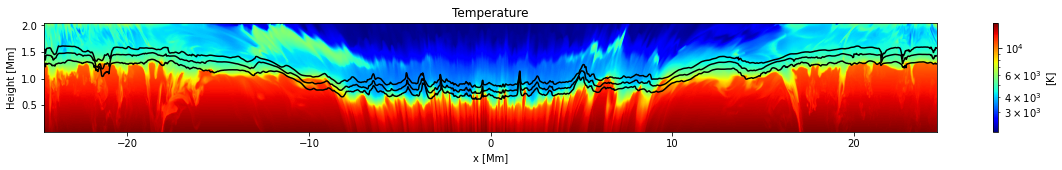

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: default base may change from np.e to 10.  To suppress this warning specify the base keyword argument.
  # This is added back by InteractiveShellApp.init_path()


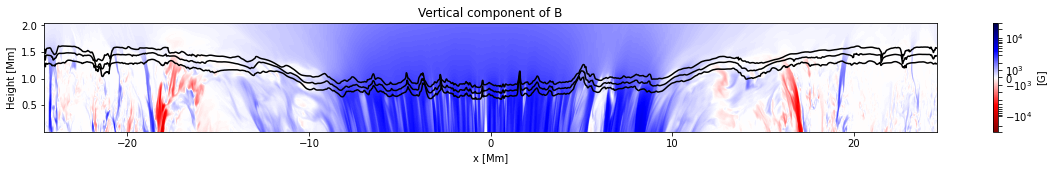

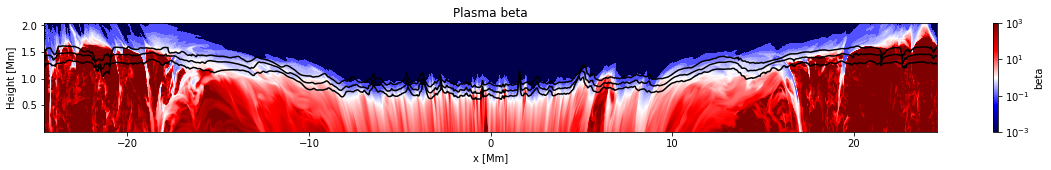

In [ ]:
zindex = 256
plt.figure(figsize=(20,2))
plt.imshow(t[:,:,256].T, aspect='auto', norm=colors.LogNorm(), cmap='jet', origin='lower', extent=(x.min(),x.max(),y.min(),y.max()))
plt.title('Temperature')
plt.xlabel('x [Mm]')
plt.ylabel('Height [Mm]')
plt.colorbar(label='[K]')
plt.contour(tau[:,:,zindex].T, levels = [0.01,0.1,1], origin='lower', colors=['black'],extent=(x.min(),x.max(),y.min(),y.max()))
plt.show()

plt.figure(figsize=(20,2))
plt.imshow(by[:,:,zindex].T, aspect='auto', norm=colors.SymLogNorm(3000,vmin=-3e4,vmax=3e4), cmap='seismic_r', origin='lower', extent=(x.min(),x.max(),y.min(),y.max()))
plt.title('Vertical component of B')
plt.xlabel('x [Mm]')
plt.ylabel('Height [Mm]')
plt.colorbar(label='[G]')
plt.contour(tau[:,:,zindex].T, levels = [0.01,0.1,1], origin='lower', colors=['black'],extent=(x.min(),x.max(),y.min(),y.max()))
plt.show()

beta = 8.0*np.pi*p[:,:,zindex]/(bx[:,:,256]**2 + by[:,:,256]**2 +bz[:,:,256]**2)
plt.figure(figsize=(20,2))
plt.imshow(beta.T, aspect='auto', norm=colors.LogNorm(vmin=0.001,vmax=1e3), cmap='seismic', origin='lower', extent=(x.min(),x.max(),y.min(),y.max()))
plt.title('Plasma beta')
plt.xlabel('x [Mm]')
plt.ylabel('Height [Mm]')
plt.colorbar(label='beta')
plt.contour(tau[:,:,zindex].T, levels = [0.01,0.1,1], origin='lower', colors=['black'],extent=(x.min(),x.max(),y.min(),y.max()))
plt.show()



### Let's inspect at some horizontal slices

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

def bokeh_image(array, x, y, title="", palette="Greys256"):
    # for availability of palettes, see https://docs.bokeh.org/en/latest/docs/reference/palettes.html
    
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], 
               x_range=(x.min(),x.max()),
               y_range=(y.min(),y.max()), 
               plot_height=300, plot_width=300*int((x.max()-x.min())/(y.max()-y.min())),
               title=title)

    # must give a vector of image data for image parameter
    p.image(image=[array.T], x=x.min(), y=y.min(), dw=x.max()-x.min(), 
            dh=(y.max()-y.min()), palette=palette, level="image", )
    p.xaxis.axis_label = '[Mm]'
    p.yaxis.axis_label = '[Mm]'
    p.grid.grid_line_width = 1
    show(p)
    return p

bokeh_image(by[:,160,:], x, z, title="B vertical [Gauss], horizontal cut", palette='Spectral11')
bokeh_image(vx[:,160,:]/1e5, x, z, title="vx [km/s], horizontal cut", palette='Spectral11')


## Let's try to sample physical properties at various optical depth levels

In [ ]:
def tau_interpolate(tau_indices, quantity, ):
    xgrid = np.arange(shape[0], dtype=np.float32) #.reshape(shape[0],1)@np.ones(shape=(1,shape[1]))
    ygrid = np.arange(shape[1], dtype=np.float32) #tau_indices[:,0,:]
    xgrid3 = np.arange(shape[0], dtype=np.float32).reshape(shape[0],1)@np.ones(shape=(1,tau_indices.shape[1]))
    result = []
    for j in range(len(z)):
        interp = RegularGridInterpolator( (xgrid,ygrid), quantity[:,:,j])
        result.append(interp((xgrid3, tau_indices[:,:,j])))
    return np.transpose(np.stack(result),[1,2,0])

# Sample physical quantity at tau_levels
by_tau = tau_interpolate(tau_indices, by)
vx_tau = tau_interpolate(tau_indices, vx)

In [ ]:
print(tau_levels)
fig, ax=plt.subplots(2,1,figsize=(25,7.5), sharex=True)
tau_pick = 1 #0 for tau=1, 1 for tau=0.1, 2 for tau=0.01
height = int(tau_indices[0:400,tau_pick,:].mean())
ax[0].imshow(by_tau[:,tau_pick,:].T, origin='lower', cmap='bwr', vmin=-4e3,vmax=4e3, extent=(x.min(),x.max(),z.min(),z.max()))
ax[0].set_title('Vertical B at tau={0:.2f}: <By> = {1:.1f} Mx/cm$^2$'.format(tau_levels[tau_pick], by_tau[:,tau_pick,:].mean()), fontsize=16)
ax[1].imshow(by[:,height,:].T, origin='lower', cmap='bwr', vmin=-4e3,vmax=4e3, extent=(x.min(),x.max(),z.min(),z.max()))
ax[1].set_title('Vertical B at y such that QS <tau> ={0:.2f}: <By> = {1:.1f}  Mx/cm$^2$'.format(tau_levels[tau_pick], by[:,height,:].mean()), fontsize=16)
ax[1].set_xlabel("Mm")
ax[0].set_ylabel("Mm")
ax[1].set_ylabel("Mm")
plt.show()

## NB: The average magnetic flux density evaluated at constant tau is 16% greater than the average flux crossing a horizontal plane!
### Exercise: Make a scatterplot or 2D histogram comparing By sampled at constant height and tau surfaces.

### Inspect field inclination angle and x-component of plasma velocity

In [ ]:
bokeh_image(np.rad2deg(np.arctan2(by[:,tau_pick,:], np.sqrt(bx[:,height,:]**2 + bz[:,height,:]**2))), x, z, title="Inclination angle [deg], tau cut", palette='Spectral11')
bokeh_image(vx_tau[:,tau_pick,:]/1e5, x, z, title="vx [km/s], tau cut", palette='Spectral11')

In [ ]:
t_tau = tau_interpolate(tau_indices, t)

In [ ]:
bokeh_image(t_tau[:,0,:], x, z, title="T[K], tau=1.0 ", palette='Greys256')

1